In [1]:
import matplotlib.pyplot as plt
import random
import sys
sys.path.append('../src')

from data import *
from model import *
from train import *
import random
from make_cosmic_web import *

ROOT = Path("..").resolve()
tng_base_path = f"{ROOT}/illustris_data/TNG50-1/output"

seed = 255
rng = np.random.RandomState(seed)
random.seed(seed)
torch.manual_seed(seed)

c0, c1, c2, c3, c4 = '#003f5c', '#58508d', '#bc5090', '#ff6361', '#ffa600'

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [2]:
reload = False #force a reload of the data to change cuts, use_loops, periodic or use_loops

## get illustris positions
snapshot = 99
h = 0.7 # cosmology h, set to 1 if you want comoving Mpc

r_link = 4 #Mpc

cuts = {"minimum_log_stellar_mass": 8,
        "minimum_log_halo_mass": 10,
       "minimum_n_star_particles": 100}

undirected = True
periodic = False
use_loops = False

use_gal = True # True = use galaxy params to infer dark matter, False = use DM params to infer galaxy stuff

pad = 1 # how much padding to add around each subbox, so the separation in total will be 2 times this

split = 8 #how many subboxes

data_path = osp.join(tng_base_path, 'cosmic_graphs', f'split_{split}_link_{int(r_link)}_pad{int(pad)}_gal{int(use_gal)}.pkl')

if osp.isfile(data_path) and not reload:
    print('File already exists')
else:
    print('Remaking dataset')
    make_webs(tng_base_path = tng_base_path, snapshot = snapshot, r_link = r_link, pad = pad,\
              cuts = cuts, use_gal = use_gal, h = h, undirected = undirected, periodic = periodic,\
              use_loops = use_loops)
    
data = pickle.load(open(data_path, 'rb'))

File already exists


In [3]:
data


[Data(x=[347, 8], edge_index=[2, 6550], edge_attr=[6550, 3], y=[347, 2], pos=[347, 3]),
 Data(x=[440, 8], edge_index=[2, 9192], edge_attr=[9192, 3], y=[440, 2], pos=[440, 3]),
 Data(x=[439, 8], edge_index=[2, 9664], edge_attr=[9664, 3], y=[439, 2], pos=[439, 3]),
 Data(x=[864, 8], edge_index=[2, 61740], edge_attr=[61740, 3], y=[864, 2], pos=[864, 3]),
 Data(x=[805, 8], edge_index=[2, 45596], edge_attr=[45596, 3], y=[805, 2], pos=[805, 3]),
 Data(x=[528, 8], edge_index=[2, 15574], edge_attr=[15574, 3], y=[528, 2], pos=[528, 3]),
 Data(x=[593, 8], edge_index=[2, 15322], edge_attr=[15322, 3], y=[593, 2], pos=[593, 3]),
 Data(x=[379, 8], edge_index=[2, 7198], edge_attr=[7198, 3], y=[379, 2], pos=[379, 3])]

In [4]:
node_features = data[0].x.shape[1]

model = EdgePointGNN(
    node_features=node_features, 
    n_layers=model_params["n_layers"], 
    k_nn=10,
    hidden_channels=model_params["n_hidden"],
    latent_channels=model_params["n_latent"],
    loop=model_params["loop"],
    estimate_all_subhalos=True,
    use_global_pooling=False
)

model.to(device)


EdgePointGNN(
  (layers): ModuleList(
    (0): EdgePointLayer()
  )
  (fc): Sequential(
    (0): Linear(in_features=96, out_features=96, bias=True)
    (1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
    (2): ReLU()
    (3): Linear(in_features=96, out_features=96, bias=True)
    (4): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
    (5): ReLU()
    (6): Linear(in_features=96, out_features=4, bias=True)
  )
)

In [5]:
optimizer = torch.optim.AdamW(
    model.parameters(), 
    lr=training_params["learning_rate"], 
    weight_decay=training_params["weight_decay"]
)


In [6]:
batch_size = 32
train_loader = DataLoader(data[1:], batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(data[:1], batch_size=batch_size, shuffle=False)



In [7]:
from train import *

training_params = dict(
    batch_size=2048,
    learning_rate=1e-4,
    weight_decay=1e-5,
    n_epochs=250,
    valid_frac=0.15, # fraction of dataset for validation
    test_frac=0.0,  # fraction of dataset for testing
)


train_losses = []
valid_losses = []
for epoch in range(training_params["n_epochs"]):
    train_loss = train(train_loader, model, optimizer, device, in_projection=False)
    valid_loss, valid_std, *_ = validate(valid_loader, model, device)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch + 1: >3d}    train loss: {train_loss: >4.1f}     valid loss: {valid_loss: >4.1f}     average valid std: {np.mean(valid_std): >5.3f}")



Epoch  10    train loss:  6.0     valid loss:  5.9     average valid std: 0.573
Epoch  20    train loss:  5.5     valid loss:  5.4     average valid std: 0.456
Epoch  30    train loss:  5.0     valid loss:  4.9     average valid std: 0.342
Epoch  40    train loss:  4.5     valid loss:  4.3     average valid std: 0.279
Epoch  50    train loss:  3.8     valid loss:  3.6     average valid std: 0.222
Epoch  60    train loss:  2.9     valid loss:  2.7     average valid std: 0.183
Epoch  70    train loss:  1.7     valid loss:  1.4     average valid std: 0.153
Epoch  80    train loss: -0.2     valid loss: -0.7     average valid std: 0.126
Epoch  90    train loss: -2.3     valid loss: -2.4     average valid std: 0.101
Epoch 100    train loss: -2.4     valid loss: -2.5     average valid std: 0.088
Epoch 110    train loss: -1.1     valid loss: -3.1     average valid std: 0.079
Epoch 120    train loss: -3.8     valid loss: -3.0     average valid std: 0.066
Epoch 130    train loss: -4.5     valid 

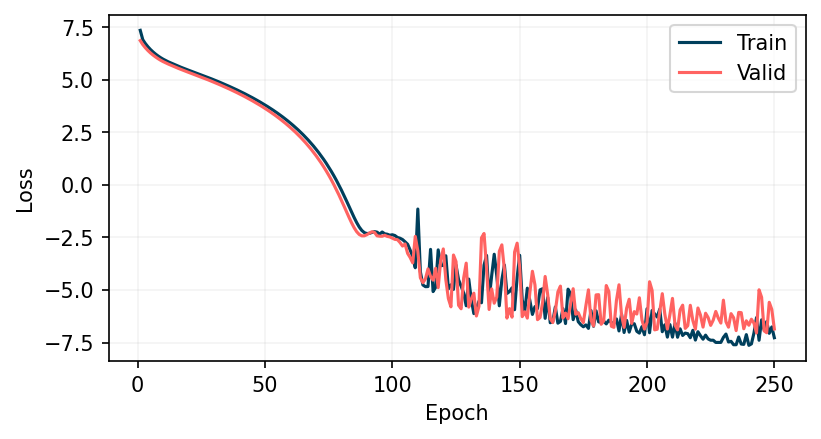

In [8]:
plt.figure(figsize=(6, 3), dpi=150)
plt.plot(1 + np.arange(training_params["n_epochs"]), train_losses, c=c0, label="Train")
plt.plot(1 + np.arange(training_params["n_epochs"]), valid_losses, c=c3, label="Valid")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(alpha=0.15)

# Hyperoptimize `k_nn`

In [9]:
import tqdm

In [18]:
validation_loss_curves = dict()

possible_k_nn = [1, 2, 3, 5, 7.5, 10]
training_params["n_epochs"] = 2000

for k_nn in tqdm.notebook.tqdm(possible_k_nn):
    model = EdgePointGNN(
        node_features=node_features, 
        n_layers=model_params["n_layers"], 
        k_nn=k_nn,
        hidden_channels=model_params["n_hidden"],
        latent_channels=model_params["n_latent"],
        loop=model_params["loop"],
        estimate_all_subhalos=True,
        use_global_pooling=False
    )

    model.to(device)

    
    optimizer = torch.optim.AdamW(
        model.parameters(), 
        lr=training_params["learning_rate"], 
        weight_decay=training_params["weight_decay"]
    )

    batch_size = 256
    train_loader = DataLoader(data[1:], batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(data[:1], batch_size=batch_size, shuffle=False)

    mhalo_losses = []
    vmax_losses = []
    for epoch in tqdm.notebook.tqdm(range(training_params["n_epochs"])):
        train_loss = train(train_loader, model, optimizer, device, in_projection=False)
        valid_loss, valid_std, y_preds, y_trues, _ = validate(valid_loader, model, device)

        mse_mhalo = np.mean((y_preds.reshape((-1, 2))[:,0] - y_trues[:,0])**2)
        mse_vmax = np.mean((y_preds.reshape((-1, 2))[:,1] - y_trues[:,1])**2)

        mhalo_losses.append(mse_mhalo)
        vmax_losses.append(mse_vmax)

    validation_loss_curves[f"Mhalo_{k_nn}"] = mhalo_losses
    validation_loss_curves[f"Vmax_{k_nn}"] = vmax_losses



  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [35]:
from scipy.ndimage import median_filter
smooth = lambda x: median_filter(x, 11)

Text(0, 0.5, 'Validation Mhalo RMSE')

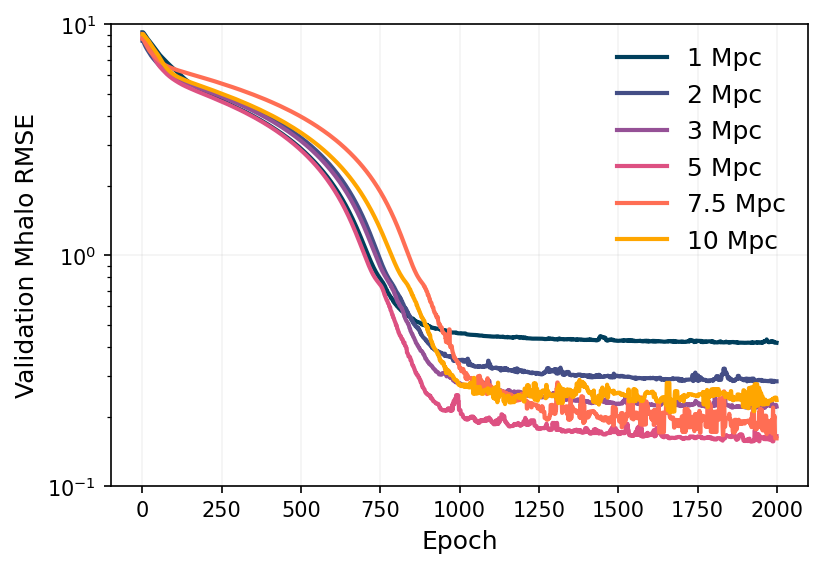

In [42]:
colors = ["#003f5c", "#444e86", "#955196", "#dd5182", "#ff6e54", "#ffa600", ]
plt.figure(figsize=(6, 4), dpi=150)
for k_nn, c in zip(possible_k_nn, colors):
    plt.plot(smooth(np.sqrt(validation_loss_curves[f"Mhalo_{k_nn}"])), c=c, lw=2,label=f"{k_nn} Mpc")
plt.legend(fontsize=12, framealpha=0)
plt.yscale('log')
plt.ylim(1e-1, 1e1)
plt.grid(alpha=0.15)

plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Validation Mhalo RMSE', fontsize=12)

Text(0, 0.5, 'Validation Vmax RMSE')

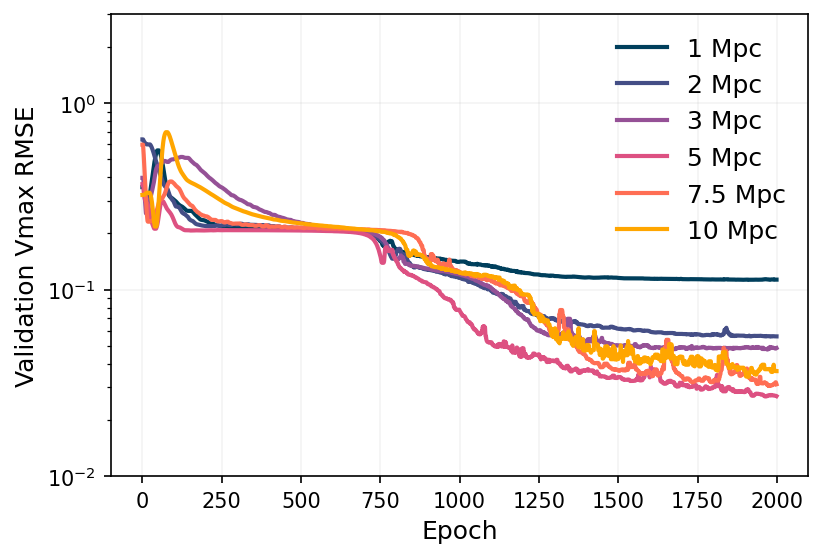

In [44]:
plt.figure(figsize=(6, 4), dpi=150)
for k_nn, c in zip(possible_k_nn, colors):
    plt.plot(smooth(np.sqrt(validation_loss_curves[f"Vmax_{k_nn}"])), c=c, lw=2,label=f"{k_nn} Mpc")
plt.legend(fontsize=12, framealpha=0)
plt.yscale('log')
plt.ylim(1e-2, 3)
plt.grid(alpha=0.15)

plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Validation Vmax RMSE', fontsize=12)

# Overfit on a single one...

In [12]:
validation_loss_curves = dict()

possible_k_nn = [5]
training_params["n_epochs"] = 10000

for k_nn in tqdm.notebook.tqdm(possible_k_nn):
    model = EdgePointGNN(
        node_features=node_features, 
        n_layers=model_params["n_layers"], 
        k_nn=k_nn,
        hidden_channels=model_params["n_hidden"],
        latent_channels=model_params["n_latent"],
        loop=model_params["loop"],
        estimate_all_subhalos=True,
        use_global_pooling=False
    )

    model.to(device)

    

    
    optimizer = torch.optim.AdamW(
        model.parameters(), 
        lr=training_params["learning_rate"], 
        weight_decay=training_params["weight_decay"]
    )

    batch_size = 256
    train_loader = DataLoader(data[1:], batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(data[:1], batch_size=batch_size, shuffle=False)

    valid_losses = []
    for epoch in tqdm.notebook.tqdm(range(training_params["n_epochs"])):
        train_loss = train(train_loader, model, optimizer, device, in_projection=False)
        valid_loss, valid_std, y_preds, y_trues, _ = validate(valid_loader, model, device)

        mse = np.mean((y_preds.reshape((-1, 2))[:,0] - y_trues[:,0])**2)

        valid_losses.append(mse)


    validation_loss_curves[k_nn] = valid_losses


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

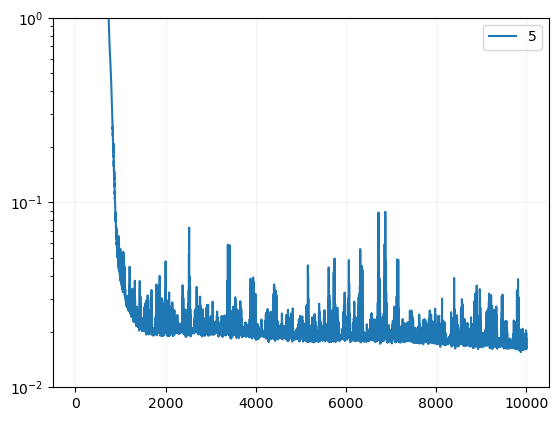

In [16]:
for key in possible_k_nn:
    plt.plot(validation_loss_curves[key], label=key)
plt.legend()
plt.yscale('log')
plt.ylim(1e-2, 1)
plt.grid(alpha=0.15)

In [14]:
y_preds

array([1.20999222e+01, 2.13656664e+00, 1.12942791e+01, 4.69859183e-01,
       1.07149868e+01, 6.95978940e-01, 1.00618191e+01, 7.82663107e-01,
       1.00309544e+01, 3.28631610e-01, 1.00459118e+01, 3.38459253e-01,
       1.00974112e+01, 3.61171722e-01, 9.46331024e+00, 1.93357289e-01,
       9.77531338e+00, 1.92292750e-01, 9.87259197e+00, 8.08389708e-02,
       9.93755436e+00, 1.57190621e-01, 9.41824150e+00, 2.29754567e-01,
       9.62664986e+00, 3.17091316e-01, 8.86992168e+00, 1.57198966e-01,
       9.23527527e+00, 2.25174606e-01, 8.63508606e+00, 1.74380720e-01,
       8.13151550e+00, 7.93156549e-02, 8.65487480e+00, 9.38286111e-02,
       8.67513561e+00, 8.72782394e-02, 8.91130733e+00, 1.47825897e-01,
       8.11962891e+00, 1.15924500e-01, 8.39721966e+00, 1.57154530e-01,
       1.17109737e+01, 1.25199783e+00, 1.03035364e+01, 5.04053950e-01,
       1.04596405e+01, 1.07642107e-01, 9.58518600e+00, 3.05117071e-01,
       8.85010815e+00, 8.95020887e-02, 9.07363319e+00, 2.23568678e-01,
      